## 회귀분석 - 경사하강법

## 1. 라이브러리 imports

In [2]:
import torch
import matplotlib.pyplot as plt

## 2. 회귀모형

> 우리가 배운 그 모형...

$$\boldsymbol{y} = \boldsymbol{XW} + \boldsymbol{\epsilon}$$

### **A. 회귀모형에서 데이터 생성**

---



In [25]:
torch.manual_seed(43052)
ones = torch.ones(100).reshape(-1, 1)  ## 100, 1 matrix
x,_ = torch.randn(100).sort()  ## output sorted random number / index list. _ is dummy for indices
x = x.reshape(-1, 1)  ## as column vector
X = torch.concat([ones, x], axis = -1)  ## -1부터 열, 행, 추가된 차수로 이해하면 되니까 이렇게 하신 듯
W = torch.tensor([[2.5], [4]])
e = torch.randn(100).reshape(-1, 1)*0.5
y = X@W + e

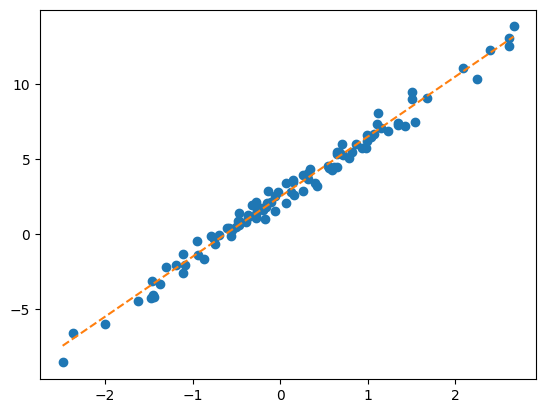

In [26]:
plt.plot(x, y, 'o')
plt.plot(x, 2.5 + 4*x, '--')
plt.show()

`-` 시도 : $(\hat{w_0}, \hat{w_1}) = (-5, 10)$을 선택하여 선을 그려보고 적당한지 판단 & 인간의 지능을 활용하여 더 나은 선을 찾아보자.

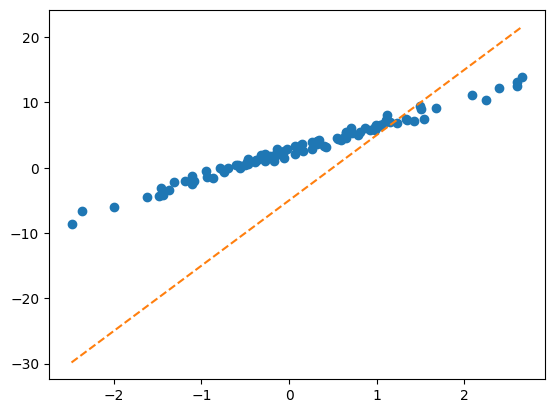

In [27]:
plt.plot(x, y, 'o')
plt.plot(x, -5+10*x, '--')
plt.show()

`-` 벡터표현으로 주황색 점선을 계산

In [28]:
W_hat = torch.tensor([[-5.0], [10.0]])  ## column vector
X.shape

torch.Size([100, 2])

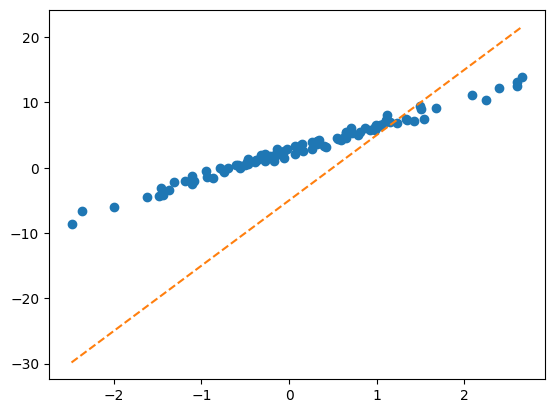

In [29]:
plt.plot(x, y, 'o')
plt.plot(x, X@W_hat, '--')
plt.show()

> 일단 이건 망한 학습인 것 같다...

## 3. 학습 전략

1. 아무 점선이나 그려본다.
2. 1단계에서 그은 점선보다 더 좋은 점선으로 바꾼다. $\to$ 이걸 어떻게 할까?
3. 1~2단계를 반복한다.

> 컴퓨터의 반복계산을 이용하여 추론(손실함수 + 경사하강법)

## 4. `1단계` 실습 - 최초의 직선

`-` 그냥 $\hat w_0 = -5, \hat w_1 = 10$으로 설정하고 임의의 선을 그어보자.

In [30]:
W_hat = torch.tensor([[-5.0], [10.0]], requires_grad = True)
W_hat

tensor([[-5.],
        [10.]], requires_grad=True)

> 끝에 `requires_grad = True`는 나중에 미분을 위한 것, 그래디언트가 필요하다는 거임...

In [31]:
y_hat = X@W_hat
y_hat

tensor([[-29.8211],
        [-28.6215],
        [-24.9730],
        [-21.2394],
        [-19.7919],
        [-19.6354],
        [-19.5093],
        [-19.4352],
        [-18.7223],
        [-18.0793],
        [-16.9040],
        [-16.0918],
        [-16.0536],
        [-15.8746],
        [-14.4690],
        [-14.3193],
        [-13.6426],
        [-12.8578],
        [-12.5486],
        [-12.4213],
        [-11.9484],
        [-11.1034],
        [-10.8296],
        [-10.6210],
        [-10.5064],
        [-10.0578],
        [ -9.8063],
        [ -9.7380],
        [ -9.7097],
        [ -9.6756],
        [ -8.8736],
        [ -8.7195],
        [ -8.6880],
        [ -8.1592],
        [ -7.7752],
        [ -7.7716],
        [ -7.7339],
        [ -7.7208],
        [ -7.6677],
        [ -7.1551],
        [ -7.0004],
        [ -6.8163],
        [ -6.7081],
        [ -6.5655],
        [ -6.4480],
        [ -6.3612],
        [ -6.0566],
        [ -5.6031],
        [ -5.5589],
        [ -5.2137],


In [32]:
# plt.plot(x, y, 'o')
# plt.plot(x, y_hat, '--')

> 그리드가 있어서 못함, 따라서 데이터만 받아서 해줘야 함.

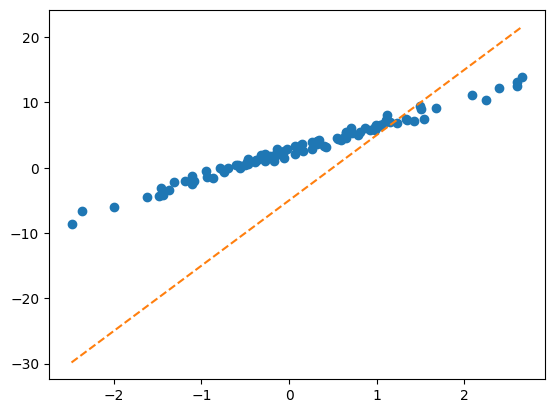

In [33]:
plt.plot(x, y, 'o')
plt.plot(x, y_hat.data, '--')  ## 그림을 그리기 위해 y_hat의 미분꼬리표를 제거
plt.show()

## 5. `2단계` 실습 : 업데이트

> 최초의 점선에 대한 '적당한 정도'를 판단하고, 더 '적당한' 점선으로 업데이트한다.

### **A. 손실함수**


---



`-` '적당한 정도'를 판단하기 위한 장치 : loss function

$loss = \Sigma_{i = 1}^{n}(y_i - \hat{y}_i)^2 = \Sigma_{i = 1}^{n}(y_i - (\hat w_0 + \hat w_1 x_i))^2$

$= (\boldsymbol y - \boldsymbol{\hat{y}})^{\top}(\boldsymbol y - \boldsymbol{\hat{y}}) = (\boldsymbol y - \boldsymbol{XW})^{\top}(\boldsymbol y - \boldsymbol{XW})$

`-` loss 함수의 특징

* $y_i \approx \hat y_i$일수록 loss값이 작다.
* $y_i \approx \hat y_i$이 되도록 $(\hat w_0, \hat w_1)$을 잘 택하면 loss값이 작다.
* **(중요)** 주황색 점선이 '적당할 수록' loss값이 작다.

In [34]:
loss = torch.sum((y - y_hat)**2)
loss

tensor(8587.6875, grad_fn=<SumBackward0>)

`-` 우리의 목표 : 이 loss(=8587.6875)를 더 줄이자.

> 궁극적으로는 아예 가능한 모든 조합 $(\hat w_0, \hat w_1)$에 대하여 가장 작은 loss를 찾으면 좋겠다. (단계 2에서 할 일은 아님...)

`-` 문제의 치환 : 생각해보니까, 우리의 문제는 수학적으로 단순화되었다.